In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=20, output_size=1, depth=2):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(depth):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Step 2: Define the Physics-Informed Neural Network (PINN)
class PINN:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)

        h = self.h = 0.1  # space step, h: the spacing between x-points
        k = self.k = 0.1  # time step, k: the spacing between t-points 

        x = torch.arange(-1, 1 + h, h)
        t = torch.arange(0, 1 + k, k)

        self.X = torch.stack(torch.meshgrid(x, t, indexing='ij')).reshape(2, -1).T.to(self.device)
        bc1 = torch.stack(torch.meshgrid(x[:1], t, indexing='ij')).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1:], t, indexing='ij')).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[:1], indexing='ij')).reshape(2, -1).T  # Initial condition (u(x, 0) = −sin(πx)

        self.X_train = torch.cat([bc1, bc2, ic]).to(self.device)
        self.y_train = torch.cat([
            torch.zeros(len(bc1)),
            torch.zeros(len(bc2)),
            -torch.sin(math.pi * ic[:, 0])
        ]).unsqueeze(1).to(self.device)

        self.X.requires_grad = True
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())

    def loss_function(self):
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)
        grads = torch.autograd.grad(u, self.X, torch.ones_like(u), create_graph=True)[0]
        du_dt, du_dx = grads[:, 1], grads[:, 0]
        du_dxx = torch.autograd.grad(du_dx, self.X, torch.ones_like(du_dx), create_graph=True)[0][:, 0]

        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)
        return loss_data + loss_pde

    def train(self, epochs=10000):
        for i in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_function()
            loss.backward()
            self.optimizer.step()
            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss.item():.5f}")

    def predict(self, x, t):
        X_test = torch.stack(torch.meshgrid(x, t, indexing='ij')).reshape(2, -1).T.to(self.device)
        with torch.no_grad():
            y_pred = self.model(X_test).cpu().numpy().reshape(len(x), len(t))
        return y_pred

# Step 3: Train and Visualize
pinn = PINN()
pinn.train()

x = torch.arange(-1, 1, 0.01)
t = torch.arange(0, 1, 0.01)
y_pred = pinn.predict(x, t)

Epoch 0, Loss: 0.24500
Epoch 100, Loss: 0.19117
Epoch 200, Loss: 0.10066
Epoch 300, Loss: 0.08974
Epoch 400, Loss: 0.08117
Epoch 500, Loss: 0.07234
Epoch 600, Loss: 0.06582
Epoch 700, Loss: 0.05651
Epoch 800, Loss: 0.04001
Epoch 900, Loss: 0.02675
Epoch 1000, Loss: 0.02188
Epoch 1100, Loss: 0.01899
Epoch 1200, Loss: 0.01765
Epoch 1300, Loss: 0.02509
Epoch 1400, Loss: 0.01519
Epoch 1500, Loss: 0.01415
Epoch 1600, Loss: 0.01321
Epoch 1700, Loss: 0.01282
Epoch 1800, Loss: 0.01162
Epoch 1900, Loss: 0.01098
Epoch 2000, Loss: 0.01053
Epoch 2100, Loss: 0.01034
Epoch 2200, Loss: 0.00937
Epoch 2300, Loss: 0.00894
Epoch 2400, Loss: 0.00897
Epoch 2500, Loss: 0.00821
Epoch 2600, Loss: 0.00794
Epoch 2700, Loss: 0.00761
Epoch 2800, Loss: 0.00732
Epoch 2900, Loss: 0.00722
Epoch 3000, Loss: 0.00683
Epoch 3100, Loss: 0.00675
Epoch 3200, Loss: 0.00639
Epoch 3300, Loss: 0.00620
Epoch 3400, Loss: 0.00779
Epoch 3500, Loss: 0.00583
Epoch 3600, Loss: 0.00574
Epoch 3700, Loss: 0.00550
Epoch 3800, Loss: 0.0053

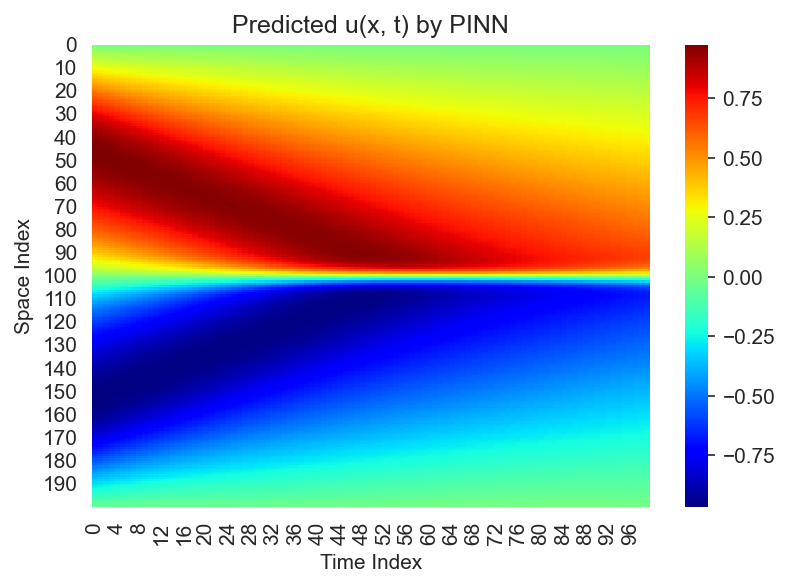

In [2]:
# Heatmap plot
sns.set_style("white")
plt.figure(figsize=(6, 4), dpi=150)
sns.heatmap(y_pred, cmap='jet')
plt.title("Predicted u(x, t) by PINN")
plt.xlabel("Time Index")
plt.ylabel("Space Index")
plt.show()

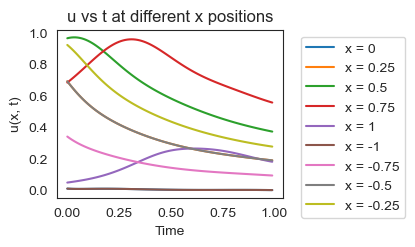

In [3]:
# Convert x positions to indices
x_positions = [0, 25, 50, 75, 99, 0, 12, 25, 37]  # Indices corresponding to [0, 0.25, 0.5, 0.75, 1, -1, -0.75, -0.5, -0.25]
x_labels = ['0', '0.25', '0.5', '0.75', '1', '-1', '-0.75', '-0.5', '-0.25']

# u vs t plot at specific x positions
plt.subplot(2, 2, 2)
for xi, label in zip(x_positions, x_labels):
    plt.plot(t, y_pred[xi, :], label=f'x = {label}')
plt.title("u vs t at different x positions")
plt.xlabel("Time")
plt.ylabel("u(x, t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [4]:
# Animation of u vs x over time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(x, y_pred[:, 0])
ax.set_xlim(-1, 1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('x')
ax.set_ylabel('u(x, t)')
ax.set_title('Solution evolution over time')
ax.grid(True)

def update(frame):
    line.set_ydata(y_pred[:, frame])
    ax.set_title(f'Solution at t = {t[frame]:.2f}')
    return line,

ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
plt.close()

# Display the animation
HTML(ani.to_jshtml())

Animation saved to: C:\Users\niles\Downloads\burgers_animation.gif


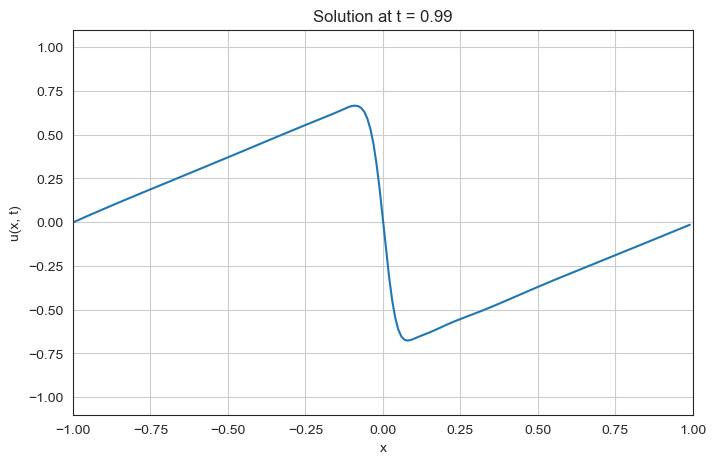

In [8]:
import os
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# Create animation
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(x, y_pred[:, 0])
ax.set_xlim(-1, 1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('x')
ax.set_ylabel('u(x, t)')
ax.set_title('Solution evolution over time')
ax.grid(True)

def update(frame):
    line.set_ydata(y_pred[:, frame])
    ax.set_title(f'Solution at t = {t[frame]:.2f}')
    return line,

ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)

# ✅ Save as GIF (Pillow supports this)
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "burgers_animation.gif")
ani.save(downloads_path, writer='pillow', fps=20)
print(f"Animation saved to: {downloads_path}")
